## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 9: Overfitting and Underfitting

### Notebook 1

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

import seaborn as sns ; sns.set()

In [2]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [3]:
# Draw idealized training and validation error curves, chosen by hand to illustrate the idea

def make_idealized_curves():
    xs = np.linspace(0, 1, 101)
    val_error = 0.15 + (1.5 * (xs-0.6)**2)
    train_error = [math.exp(-(2*x))-.35 for x in xs]
    plt.plot(xs, val_error, color='red', label='validation error')
    plt.plot(xs, train_error, color='blue', label='training error')
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Error", fontsize=14)
    plt.xticks([0, .2, .4, .6, .8, 1],[0, 10, 20, 30, 40, 50], fontsize=14)
    plt.yticks([],[])
    plt.legend(loc='lower left', fontsize=14)
    plt.title("Idealized Error Curves")
    file_helper.save_figure("ideal-error-curves")
    plt.show()

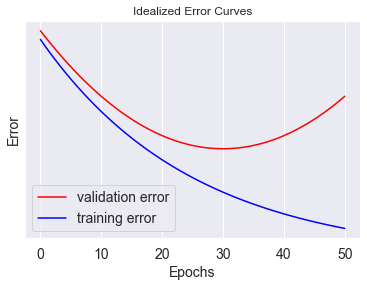

In [4]:
make_idealized_curves()

In [5]:
# fit a line or polynomial (as determined by fit_degree) to the data

def quick_fit_and_predict(fit_degree, X_train, y_train, X_test):
    if fit_degree < 1:
        # we use 0 degree fit to signal linear interpolation
        y_predict = [np.interp(x, X_train, y_train) for x in X_test]
    else:
        polynomial_features = PolynomialFeatures(degree=fit_degree, include_bias=False)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("linear_regression", linear_regression)])
        pipeline.fit(X_train[:, np.newaxis], y_train)
        y_predict = pipeline.predict(X_test[:, np.newaxis])
    return y_predict

In [6]:
# Some hand-created data pretending to be someone's hand-set tempos during the day

def get_tempo_data():
    xs = np.linspace(0, 1, 30)
    ys = [.8, .7, .55, .5, .65, .6, .63, .6, .45, .4, .48, .42, .51, 
          .65, .63, .68, .75, .72, .8, .82, .8, .7, .74, .7, .77, .6,
         .5, .45, .42, .4]
    highres_xs = np.linspace(0, 1, 300)
    return (xs, ys, highres_xs)

In [7]:
# Show the data and a fit, by degree

def show_tempo_match(degree):
    (xs, ys, highres_xs) = get_tempo_data()
    y_predict = quick_fit_and_predict(degree, xs, ys, highres_xs)
    plt.scatter(xs, ys, s=50)
    plt.plot(highres_xs, y_predict, color='red', lw=2)
    plt.xticks([0, .2, .4, .6, .8, 1],['9:00 am', '10:30 am', '12:00', '1:30 pm', '3:00 pm', '4:30 pm'], fontsize=14)
    plt.yticks([.3, .45, .6, .75, .9],[0, .25, .5, .75, 1], fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('tempo', fontsize=14)
    file_helper.save_figure('tempo-match-'+str(degree))

In [8]:
# Show just the tempo data

def show_tempo_data():
    (xs, ys, highres_xs) = get_tempo_data()
    plt.scatter(xs, ys, s=50)
    plt.xticks([0, .2, .4, .6, .8, 1],['9:00 am', '10:30 am', '12:00', '1:30 pm', '3:00 pm', '4:30 pm'], fontsize=14)
    plt.yticks([.3, .45, .6, .75, .9],[0, .25, .5, .75, 1], fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('tempo', fontsize=14)
    file_helper.save_figure('tempo-data')

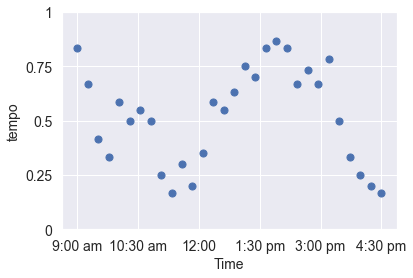

In [9]:
show_tempo_data()

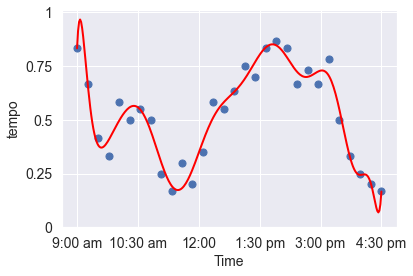

In [10]:
show_tempo_match(15)

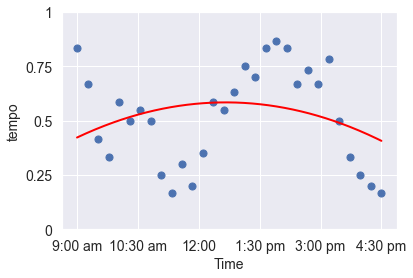

In [11]:
show_tempo_match(2)

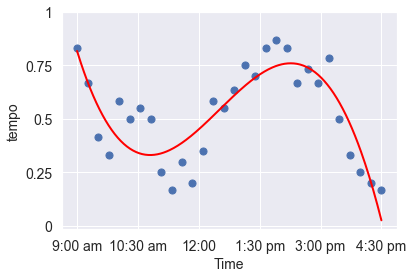

In [12]:
show_tempo_match(4)

In [13]:
# Show L1 and L2 norms

def show_L1_L2(values, title):
    L1 = np.sum([abs(v) for v in values])
    L2 = np.sqrt(np.sum([v**2 for v in values]))
    xs = range(3+len(values))
    ys = values + [0, L1, L2]
    red = '#A84949'
    yel = '#B0A14C'
    blu = '#4C72B0'
    clrs = ([blu]*(len(values)+1)) + [yel, red]
    plt.bar(xs, ys, align='center', color=clrs)
    xvals = [' '] * (1+len(values)) + ['L1', 'L2']
    plt.xticks(xs, xvals, fontsize=14)
    ysteps = np.linspace(0, max(L1, L2), 5)
    ysteps_labels = ['{:.2f}'.format(y) for y in ysteps]
    plt.yticks(ysteps, ysteps_labels, fontsize=14)
    plt.title(title, fontsize=16)

In [14]:
# Show L1 and L2 norms for two datasets

def make_L1_L2_grid():
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    show_L1_L2([.3, .1, .2, .4, .7], 'Values in the range [0,1]')
    plt.subplot(1, 2, 2)
    show_L1_L2([2, 9, 5, 7, 3], 'Values in the range [2,9]')
    plt.tight_layout()
    file_helper.save_figure('L1-L2-grid')
    plt.show()

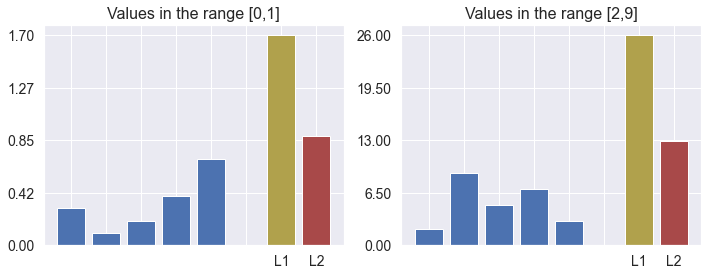

In [15]:
make_L1_L2_grid()